# Predicting cancerous mutations from images of human cells

## Goals (3 min)

In previous cases we learned the fundamentals of an artificial neural network and how powerful they can be in analyzing complex data, especially large datasets with highly nonlinear relationships. However, we were still working with traditional data composed of structured feature vectors. In this case, you will learn about a particular type of neural network architecture, the **convolutional neural network**, which can handle more complex data, like images. You will learn not only the structure of this kind of model, but also how to train and evaluate it using a modern data science toolbox. You will also be able to assess your convolutional neural network's strengths and limitations in comparison to simpler models.

In [1]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt

# general
from numpy import mean
from numpy import std
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# image processing
from PIL import Image # <-- if you cannot install, comment out and find the cell containing %%help%%
# import pickle       # <-- these packages are optional, only if you want to explore image processing
# import glob
# import os

# convolutional neural network
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# random forest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# lasso
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


## Introduction (7 min)

<img src=files/hook.jpg width="500">

**Business Context.** You work for a medical research group that is working to develop a novel diagnostic method that identifies an individual’s predisposition to cancer based on images of human cells. This tool could be revolutionary for identifying specific mutations on the cancer-associated p53 gene without genetic testing - the procedure could be a lot cheaper and less invasive. Additionally, if we understand what features of the images are being used to distinguish the mutant cells, this could help generate further hypotheses and experiments for underlying biological differences. There are three different kinds of mutations you want to be able to detect, based on hundreds of images of cells photographed under a microscope. You also need to be able to detect whether there is a mutation at all.

**Business Problem.** You have been tasked with **predicting the mutation of a cell given any information you could obtain from these photographs**. Specifically, you will be using both raw images of human fibroblast cells and features extracted using image processing algorithms.

**Analytical Context.** In the last case, you became familiar with basic neural networks by predicting the fair market value of used cars. The dataset you used was some of the standard structured data you have probably seen before: features scraped from Craigslist. In this case, you will be working with image data and learn about more advanced neural networks: in particular, the **convolutional neural network** (CNN). You will practice using and comparing a range of machine learning classifiers, both traditional and more modern, in order to tackle the question: *Can we predict cancerous mutations from images of human cells?*

The case is structured as follows: (1) you will understand the raw image dataset; (2) you will build, train, and evaluate a simple CNN from scratch; (3) you will build, train, and evaluate a more complex CNN using `keras`; (4) you will build, train, and evaluate a more traditional machine learning classifier (LASSO) on a dataset of features pre-extracted from the raw images; and finally (5) you will evaluate and compare the performances of the different classifiers and weigh their strengths and weaknesses.

<img src=files/cellimage.jpg width="500">

In the image above, you can see a photograph of human lung fibroblast cells under a microscope. The green is the body (the cytoplasm) of the cell and the pink is the nucleus. Biotechnology has advanced so that we can actually "color" cells and photograph them with high-definition miscroscopes. We can also do this at large scales, photographing thousands of cells at a time. Nowadays, scientists can even color different parts of a cell (such as the nucleus above, but alse other organelles) by making different proteins light up with photofluorescence. As in many other industries, this has led to an explosion of data, because every cell now has countless features we could observe from a single image.

What we will explore in this case is how to work with this image data. However, many of the challenges we will face in this case are ones not unique to the problem of understanding cells - they are helpful if you ever need to work with image data.

## Preprocessing the images (10 min)

Take a look at an example of a raw image from each class in greyscale (they were originally in color). The first image is of a cell with the first mutation (the photographs of cells are enhanced to refine edges and decrease blurring). The next image is an example of a cell with the second mutation. Then there is an example of a cell with the third mutation, which is fainter because they come from a lab that does not do image enhancements. Finally, there is an example of a cell where there are no mutations. It comes from a lab where the cell borders are circled manually by a technician:

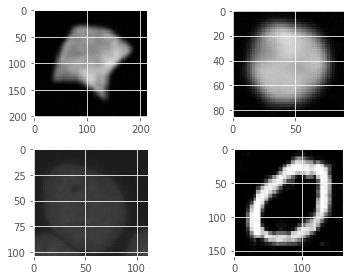

In [2]:
# %%help%% If you are having trouble installing PIL, you can just open the images
# in the sample_images directory to view them, instead of running this code.

sample_images_path = "sample_images/"
sample_images_list = ["mut_1", "mut_2", "mut_3", "normal"]
for i,img in zip(range(len(sample_images_list)), sample_images_list):
    pil_im = Image.open(sample_images_path + img + ".png", 'r')
    # plot raw pixel data
    plt.subplot(2,2,1+i)
    plt.imshow(np.asarray(pil_im),cmap="Greys")
plt.tight_layout()
plt.show()

In the interest of time, we will be working with a preprocessed dataset of the images. The code block below shows some of the transformations that were performed on the raw PNG files. Notice that we resized, centered, and scaled the images and also adjusted for some contrast differences, but we did not adjust for blur. Try to think about what the implications might be for some of these decisions:

In [3]:
## function to resize image, preserving aspect ratio
#def resizeAspect(im, size):
#    w,h = im.size
#    aspect=max(size[0]/float(w), size[1]/float(h))
#    return im.resize((int(w*aspect),int(h*aspect)),Image.ANTIALIAS)
#
#data_path = "raw_images/"
#imgList=glob.glob(data_path+"*.png")             # find all png images in a directory
#
#num = 0
#for img in imgList:                              # loop through all found images
#    im = Image.open(img)                         # open the image
#    print("resizing:",os.path.basename(img))
#    w,h = im.size                                # get image width and height
#    if min(w,h)>28:                              # check if either dimension is greater then 50
#        im=resizeAspect(im,(28,28))              # re-size image
#        w,h = im.size                            # update image size
#    center = [int(w/2.0),int(h/2.0)]             # calculate center
#    box = (center[0]-14, center[1]-14, center[0]+14, center[1]+14) # defines a box where you want it to be cropped
#    croppedIm = im.crop(box)                     # crop the image
#    # croppedIm.show()                           # show the cropped image
#    print(croppedIm.size)
#    fileName, fileExtension=os.path.splitext(img)
#    croppedIm.save("images/"+fileName[len(data_path):]+'_crop.png', "PNG")  # save the cropped image

After all the preprocessing is complete, we can load in our image data via a CSV file and take a look at our adjusted images. All the dimensions are the same and some of the differences in contrast have been fixed.

In [4]:
all_dat     = np.asfarray(pd.read_csv('data/all_dat.csv'))

# the first column is the labels
all_imgs    = np.asfarray(all_dat[:, 1:])
all_labels  = np.asfarray(all_dat[:, :1])

print(all_imgs.shape)
print(all_labels.shape)

(1200, 784)
(1200, 1)


In [5]:
pd.DataFrame(all_imgs).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
1,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
2,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
3,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
4,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922


In [6]:
# for i,x in zip(range(9),[114, 148,  75, 337, 352, 266, 261, 136, 134]):
#     img = all_imgs[x] + np.random.normal(0,0.03,all_imgs.shape[1])
#     img = img.reshape((28,28))
#     plt.subplot(3,3,1+i)
#     plt.imshow(img,cmap="Greys")
# plt.tight_layout()
# plt.show()

# new_imgs = all_imgs
# new_labels = all_labels
# for i in range(all_imgs.shape[0]):
#     new_imgs[i] = all_imgs[i] + np.random.normal(0,0.03,all_imgs.shape[1])

# all_imgs = np.vstack([new_imgs, all_imgs])
# print(all_imgs.shape)
# 
# all_labels = np.vstack([new_labels, all_labels])
# print(all_labels.shape)

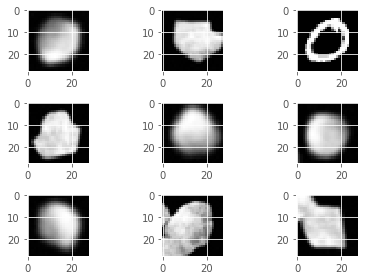

In [7]:
for i,x in zip(range(9),[614, 348,  75, 537, 752, 866, 661, 536, 434]):
    img = all_imgs[x].reshape((28,28))
    plt.subplot(3,3,1+i)
    plt.imshow(img,cmap="Greys")
plt.tight_layout()
plt.show()

## Understanding the problem and image dataset (20 min)

Let's load in the preprocessed images and understand the information available to us to answer the question of interest.

### Exercise 1: (10 min)

#### 1.1
What is the outcome variable we seek to predict?

(a) the number of mutations (integer variable);

(b) whether there is a mutation (binary variable);

(c) the type of mutation (categorical variable);

(d) something else.

**Answer.** (c), specifically `No Mutation`, `Mutation 1`, `Mutation 2`, or `Mutation 3`.

#### 1.2

Do we need to transform this outcome variable to train a neural network? Furthermore, if we do need to transform it, how should we represent this outcome variable?

**Answer.** Yes, it needs to be transformed. The outcome variable is numeric (one number for each of the four possible mutation specifications). However, integer encoding can result in the classifier falsely assume an ordering between the outcomes (e.g. `Mutation 1` > `No Mutation`). Therefore, it is recommended to use one-hot representation, because the outcomes variable will be numeric but unordered.

#### 1.3

Is there a similar problem in which you could imagine integer encoding to be desirable?

**Answer.** Yes, if we are interested in predicting the **number of mutations** rather than the type of mutation, for instance.

#### 1.4

Is it important for the images to be the same size and dimensions? Why or why not?

**Answer.** Convolutional neural networks are **not** scale invariant. If we train on images of the same size and/or fixed resolution, our neural network will fail on images of smaller or larger sizes.

#### 1.5

If it is important for the images to be the same size and dimension, but cropping and rescaling the images is **not** desirable or feasible, what are other approaches we can take?

**Answer.** 1) multi-scale **training** of images of different sizes in fully-convolutional nets in order to make the model more robust to changes in scale; and 2) having multi-scale **architecture**. You can explore these papers for further information: [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144) and [High-Resolution Representations for Labeling Pixels and Regions](https://arxiv.org/pdf/1904.04514.pdf).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(all_imgs, all_labels,
                                                    test_size=0.1, stratify=all_labels,
                                                    random_state=13)

In [9]:
image_size = 28 # width and length
no_of_different_labels = 4 #  i.e. 0, 1, 2, 3 mutations
image_pixels = image_size * image_size

# already ensured there are no zeroes and ones in the inputs as this might affect weight updates
# but if you get raw RGB values, you can adjust like this:
# fac = 0.99 / 255
# prep_pixels = raw_pixels * fac + 0.01

train_imgs = X_train
test_imgs = X_test
train_labels = y_train
test_labels = y_test

In [10]:
lr = np.arange(no_of_different_labels)

# recall what one-hot representation looks like
for label in range(no_of_different_labels):
    one_hot = (lr==label).astype(np.int)
    print("label: ", label, " in one-hot representation: ", one_hot)

# transform labels into one-hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float)
test_labels_one_hot = (lr==test_labels).astype(np.float)

# we don't want zeroes and ones in the labels as this might affect weight updates
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99

label:  0  in one-hot representation:  [1 0 0 0]
label:  1  in one-hot representation:  [0 1 0 0]
label:  2  in one-hot representation:  [0 0 1 0]
label:  3  in one-hot representation:  [0 0 0 1]


In [11]:
## this code dumps the data into a .pkl file to make it easier to reuse the Python objects we've created
#with open("data/pickled_dat.pkl", "bw") as fh:
#    data = (train_imgs, 
#            test_imgs, 
#            train_labels,
#            test_labels,
#            train_labels_one_hot,
#            test_labels_one_hot)
#    pickle.dump(data, fh)

## Building and training a single-layer neural network (45 min)

Let's now build and train on the raw images a simple single-layer, single-epoch neural network from scratch (using only `numpy` and `scikit`). In the previous case, recall that we used the `Sequential` functionality from `keras`. We will be using more out-of-the-box tools later in this case, but right now, we want to be sure you understand a deeper dive into the neural network construction itself.

We will be constructing a very basic neural network from scratch in a class `NeuralNetwork`. This is the skeleton of the code we are writing:

```
class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        ...
        
    def train(self, input_vector, target_vector):
        ...
        
    def run(self, input_vector):
        return ...
            
    def confusion_matrix(self, data_array, labels):
        return ...
    
    def evaluate(self, data, labels):
        return ...
```

We will also be adding the functions `precision` and `recall` for convenience.

For fully connected neural networks, there are three essential questions that define the network’s **architecture**:

1. How many layers are there?
1. How many nodes are there in each of those layers?
1. What activation function is used at each of those layers?

Remember that there is an activation function (usually the logistic regression function) between each pair of layers, which allows our network to develop non-linear sensitivities. When there are multiple layers, we can keep adding more linear combinations of the nodes, which will lead to more complex non-linear models. We already saw the simple non-linear activation function *ReLu*. In this case, we will also be using the sigmoid function as an activation function, but the key thing to remember is that there are [many different activation functions](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/) and your problem's structure and constraints will guide you regarding which one is best to use. For instance, the image classification task at hand makes the ReLU a good option for us due to its efficiency.

### Exercise 2: (5 min)

In the code below, fill in the missing lines containing `???`:

```
def sigmoid(x):
    """
    Sigmoid function (decays exponentially at the tails).
    """
    return ???

def relu(x):
    """
    Rectified linear unit function (negative elements set exactly to zero).
    """
    return ???
```

**Answer.** 

In [12]:
@np.vectorize
def sigmoid(x):
    """
    Sigmoid function (decays exponentially at the tails).
    """
    return 1 / (1 + np.e ** -x)

@np.vectorize
def relu(x):
    """
    Rectified linear unit function (negative elements set exactly to zero).
    """
    return np.maximum(x, 0)

---

Notice the `@` symbol in the solution: this signals that the function that follows is a Python decorator, which can make function changes easier to implement and more readable. You can learn more [here](https://stackoverflow.com/questions/19844177/what-does-the-symbol-do-in-ipython-python). Now, let's plot the activation functions so we can examine their differences visually. The ReLu function should look familiar to you:

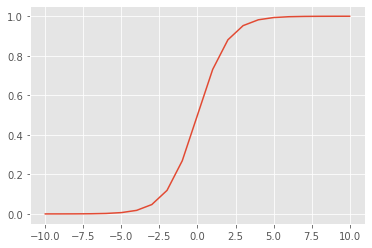

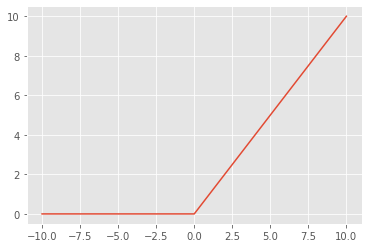

In [13]:
def plot_activation_function(activation_function):
    """
    Plots the given activation_function
    for the domain (-10, 10).
    """
    # define a series of inputs
    series_in = [x for x in range(-10, 11)]
    # calculate outputs for our inputs
    series_out = [activation_function(x) for x in series_in]
    # line plot of raw inputs to rectified outputs
    plt.plot(series_in, series_out)
    plt.show()
    
plot_activation_function(sigmoid)
plot_activation_function(relu)

Let's review what a neural network's parameters are (the `weight_matrices` in our `NeuralNetwork` class). Our `train` function must learn what the contents of the weight matrices are, and the `run` function will then apply those weights to new input (e.g. test data). If you are mathematically inclined, here is some notation to help you understand how the values of nodes are updated with weights and activation functions.

At layer $\ell$ in the network, for $\ell = 1, \ldots, L$, define:

* $n_\ell$ as the number of nodes in the layer
* $W_\ell$ as the weight matrix
* $W_{\ell,jk}$ as the weight from node $j$ in layer $\ell-1$ to node $k$ in layer $\ell$
* $a_\ell$ as the activation vector, where $a_{\ell,j}$ is the activation produced by node $j$ in layer $\ell$
* $a_0$ is the input vector

We will denote $z_\ell = W_\ell^T a_{\ell-1} + b_\ell$ for convenience. In a neural network, we have the following recurrence relation:

$$a_\ell = \phi(W_\ell^T a_{\ell-1} + b_\ell) = \phi(z_\ell),$$

$$a_0 = x,$$

for layers $\ell = 1, \ldots, L$. (What we are not mentioning here are the bias parameters for simplicity. You can read more on them [here](https://medium.com/deeper-learning/glossary-of-deep-learning-bias-cf49d9c895e2).)

Use what you have learned about how the nodes in a neural network are updated in order to fill in the lines of code below.

```
    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """
        
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
-->     output_hidden = ???
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
-->     output_network = ???
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)
```

### Exercise 3: (5 min)

#### 3.1

In the code above, fill in the missing code for `output_hidden`.

**Answer.** `output_hidden = activation_function(output_vector1)`

#### 3.2

In the code above, fill in the missing code for `output_network`.

**Answer.** `output_network = activation_function(output_vector2)`

We have now finished writing the `train` portion of our `NeuralNetwork` class. As you will see below, the `run` function is very similar: we simply apply the weights that we have just learned! The last functions we need in our class are to evaluate model performance, which we will do using `confusion_matrix`, `precision`, and `recall`.

#### 3.3

In your own words, how would you describe "precision" and "recall"?

**Answer.** Precision is also called the positive predictive value; it measures the fraction of relevant instances to retrieved instances. Recall is also called sensitivity; it measures how many relevant instances were actually retrieved. For more information, refer to this link: [Towards Data Science](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).

<img src=files/precision_v_recall.png width="600">

In [14]:
## we load all the separate objects from the .pkl file
#with open("data/pickled_dat.pkl", "br") as fh:
#    data = pickle.load(fh)
#
#train_imgs = data[0]
#test_imgs = data[1]
#train_labels = data[2]
#test_labels = data[3]
#train_labels_one_hot = data[4]
#test_labels_one_hot = data[5]
#
#image_size = 28
#no_of_different_labels = 4
#image_pixels = image_size * image_size

In [15]:
activation_function = sigmoid

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ 
        method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))
        
    
    def train(self, input_vector, target_vector):
        """
        method to train the neural network on input_vector
        with output being target_vector
        """
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp

        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)
        

    def run(self, input_vector):
        """
        method to run (trained) neural network on input_vector
        using the weight matrices learned
        """
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
    
    
    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((4, 4), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    
    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
        
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

### Exercise 4: (20 min)

#### 4.1

Using our `NeuralNetwork` class, create an instance with 128 hidden nodes and a learning rate of 0.01 (the default in `keras`). Be sure to use the appropriate `no_of_in_nodes` (number of input nodes) and `no_of_out_nodes` for the problem at hand. Call this neural network `ANN`.

**Answer.**

In [16]:
ANN = NeuralNetwork(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 4, # this should correspond to the number of labels
                    no_of_hidden_nodes = 128,
                    learning_rate = 0.01)

In [17]:
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])

print("true | pred |  P()")
print("_____________________")
for i in range(10):
    res = ANN.run(test_imgs[i])
    print(" ", int(test_labels[i][0]), " | ", np.argmax(res), "  | ", round(np.max(res), 3))

true | pred |  P()
_____________________
  2  |  3   |  0.411
  3  |  3   |  0.549
  2  |  3   |  0.447
  0  |  0   |  0.955
  3  |  3   |  0.529
  2  |  3   |  0.374
  2  |  2   |  0.331
  2  |  3   |  0.383
  0  |  0   |  0.916
  1  |  2   |  0.33


In [18]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", round(corrects / ( corrects + wrongs), 3))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy test:  ", round(corrects / ( corrects + wrongs), 3))

print("")
print("confusion matrix:")
cm = ANN.confusion_matrix(train_imgs, train_labels)
print(cm)

print("")
for i in range(4):
    print("mutant " + str(i) + ",",
          "precision: ", round(ANN.precision(i, cm), 2),
          " recall: ", round(ANN.recall(i, cm), 2))

accuracy train:  0.587
accuracy test:   0.583

confusion matrix:
[[270   0   0   0]
 [  0   0   0   0]
 [  0 102  94   0]
 [  0 168 176 270]]

mutant 0, precision:  1.0  recall:  1.0
mutant 1, precision:  0.0  recall:  nan
mutant 2, precision:  0.35  recall:  0.48
mutant 3, precision:  1.0  recall:  0.44


/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in long_scalars


In [19]:
epochs = 30

for epoch in range(epochs):  
    print("epoch:", epoch)
    for i in range(len(train_imgs)):
        ANN.train(train_imgs[i],
                  train_labels_one_hot[i])
    
    corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
    print("accuracy train: ", round(corrects / ( corrects + wrongs), 3))
    corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
    print("accuracy test:  ", round(corrects / ( corrects + wrongs), 3))

epoch: 0
accuracy train:  0.719
accuracy test:   0.708
epoch: 1
accuracy train:  0.734
accuracy test:   0.717
epoch: 2
accuracy train:  0.738
accuracy test:   0.733
epoch: 3
accuracy train:  0.74
accuracy test:   0.733
epoch: 4
accuracy train:  0.747
accuracy test:   0.733
epoch: 5
accuracy train:  0.76
accuracy test:   0.75
epoch: 6
accuracy train:  0.781
accuracy test:   0.758
epoch: 7
accuracy train:  0.79
accuracy test:   0.775
epoch: 8
accuracy train:  0.804
accuracy test:   0.733
epoch: 9
accuracy train:  0.808
accuracy test:   0.758
epoch: 10
accuracy train:  0.819
accuracy test:   0.758
epoch: 11
accuracy train:  0.82
accuracy test:   0.767
epoch: 12
accuracy train:  0.828
accuracy test:   0.767
epoch: 13
accuracy train:  0.835
accuracy test:   0.775
epoch: 14
accuracy train:  0.843
accuracy test:   0.775
epoch: 15
accuracy train:  0.847
accuracy test:   0.792
epoch: 16
accuracy train:  0.85
accuracy test:   0.792
epoch: 17
accuracy train:  0.851
accuracy test:   0.8
epoch: 18


There are many factors that can contribute to the performance of a neural network. These include which loss function is used (we will use **categorical cross entropy**), which optimization algorithm is used (we will use **stochastic gradient descent**), how many training epochs to run before stopping, and the batch size within each epoch. The performance is also influenced by the number of hidden layers.

#### 4.2 (optional)

How would you extend this code to account for multiple hidden layers?

**Answer.** One possible implementation is below:

In [20]:
class NeuralNetwork:
    
    def __init__(self, 
                 network_structure, # ie. [input_nodes, hidden1_nodes, ... , hidden_n_nodes, output_nodes]
                 learning_rate,
                 bias=None):  

        self.structure = network_structure
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()
    
    
    def create_weight_matrices(self):
        bias_node = 1 if self.bias else 0
        self.weights_matrices = []
        
        layer_index = 1
        no_of_layers = len(self.structure)
        while layer_index < no_of_layers:
            nodes_in = self.structure[layer_index-1]
            nodes_out = self.structure[layer_index]
            n = (nodes_in + bias_node) * nodes_out
            rad = 1 / np.sqrt(nodes_in)
            X = truncated_normal(mean=2, 
                                 sd=1, 
                                 low=-rad, 
                                 upp=rad)
            wm = X.rvs(n).reshape((nodes_out, nodes_in + bias_node))
            self.weights_matrices.append(wm)
            layer_index += 1
    
        
    def train(self, input_vector, target_vector):
        no_of_layers = len(self.structure)
        input_vector = np.array(input_vector, ndmin=2).T
        layer_index = 0
        # output/input vectors of the various layers
        res_vectors = [input_vector]
        while layer_index < no_of_layers - 1:
            in_vector = res_vectors[-1]
            if self.bias:
                # adding bias node to the end of the in_vector
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )
                res_vectors[-1] = in_vector
            x = np.dot(self.weights_matrices[layer_index], 
                       in_vector)
            out_vector = activation_function(x)
            # the output of one layer is the input of the next one
            res_vectors.append(out_vector)    
            layer_index += 1
        
        layer_index = no_of_layers - 1
        target_vector = np.array(target_vector, ndmin=2).T
         # input vectors to the various layers
        output_errors = target_vector - out_vector  
        while layer_index > 0:
            out_vector = res_vectors[layer_index]
            in_vector = res_vectors[layer_index-1]

            if self.bias and not layer_index==(no_of_layers-1):
                out_vector = out_vector[:-1,:].copy()

            tmp = output_errors * out_vector * (1.0 - out_vector)     
            tmp = np.dot(tmp, in_vector.T)
                
            self.weights_matrices[layer_index-1] += self.learning_rate * tmp
            
            output_errors = np.dot(self.weights_matrices[layer_index-1].T, 
                                   output_errors)
            if self.bias:
                output_errors = output_errors[:-1,:]
            layer_index -= 1
            
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray

        no_of_layers = len(self.structure)
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, 
                                            [self.bias]) )
        in_vector = np.array(input_vector, ndmin=2).T

        layer_index = 1
        # input vectors to the various layers
        while layer_index < no_of_layers:
            x = np.dot(self.weights_matrices[layer_index-1], 
                       in_vector)
            out_vector = activation_function(x)
            
            # input vector for next layer
            in_vector = out_vector
            if self.bias:
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )            
            
            layer_index += 1
  
        return out_vector
    
    
    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((4, 4), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    
    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
    
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [21]:
ANN = NeuralNetwork(network_structure=[image_pixels, 64, 8, 4],
                               learning_rate=0.01,
                               bias=None)

for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])
    
print("true | pred |  P()")
print("_____________________")
for i in range(10):
    res = ANN.run(test_imgs[i])
    print(" ", int(test_labels[i][0]), " | ", np.argmax(res), "  | ", round(np.max(res), 3))

true | pred |  P()
_____________________
  2  |  3   |  0.372
  3  |  3   |  0.373
  2  |  3   |  0.373
  0  |  0   |  0.607
  3  |  3   |  0.373
  2  |  3   |  0.372
  2  |  3   |  0.371
  2  |  3   |  0.372
  0  |  0   |  0.585
  1  |  3   |  0.371


In [22]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects / ( corrects + wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy test:  ", corrects / ( corrects + wrongs))

print("")
print("confusion matrix:")
cm = ANN.confusion_matrix(train_imgs, train_labels)
print(cm)

print("")
for i in range(4):
    print("mutant ", i, "- precision: ", round(ANN.precision(i, cm), 2), " recall: ", round(ANN.recall(i, cm), 2))

accuracy train:  0.5
accuracy test:   0.5

confusion matrix:
[[270   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0 270 270 270]]

mutant  0 - precision:  1.0  recall:  1.0
mutant  1 - precision:  0.0  recall:  nan
mutant  2 - precision:  0.0  recall:  nan
mutant  3 - precision:  1.0  recall:  0.33


/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in long_scalars


In [23]:
epochs = 30

for epoch in range(epochs):  
    print("epoch:", epoch)
    for i in range(len(train_imgs)):
        ANN.train(train_imgs[i],
                  train_labels_one_hot[i])
    
    corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
    print("accuracy train: ", round(corrects / ( corrects + wrongs), 3))
    corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
    print("accuracy test:  ", round(corrects / ( corrects + wrongs), 3))

epoch: 0
accuracy train:  0.5
accuracy test:   0.5
epoch: 1
accuracy train:  0.5
accuracy test:   0.5
epoch: 2
accuracy train:  0.5
accuracy test:   0.5
epoch: 3
accuracy train:  0.5
accuracy test:   0.5
epoch: 4
accuracy train:  0.5
accuracy test:   0.5
epoch: 5
accuracy train:  0.5
accuracy test:   0.5
epoch: 6
accuracy train:  0.5
accuracy test:   0.5
epoch: 7
accuracy train:  0.712
accuracy test:   0.658
epoch: 8
accuracy train:  0.738
accuracy test:   0.717
epoch: 9
accuracy train:  0.742
accuracy test:   0.717
epoch: 10
accuracy train:  0.74
accuracy test:   0.725
epoch: 11
accuracy train:  0.747
accuracy test:   0.725
epoch: 12
accuracy train:  0.747
accuracy test:   0.733
epoch: 13
accuracy train:  0.746
accuracy test:   0.75
epoch: 14
accuracy train:  0.748
accuracy test:   0.75
epoch: 15
accuracy train:  0.749
accuracy test:   0.75
epoch: 16
accuracy train:  0.749
accuracy test:   0.75
epoch: 17
accuracy train:  0.749
accuracy test:   0.75
epoch: 18
accuracy train:  0.749
acc

---

Regular neural nets may not scale well to full images. In our dataset of cells, images were originally of size 200x200x3 (200 wide, 200 high, 3 RGB color channels), so a single fully-connected neuron in the first hidden layer of a regular neural network would have 200*200*3 = 120,000 weights. This is unmanageable; moreover, we would want to have more than just a single neuron in our network. This huge number of parameters would lead to overfitting, which is why we scaled down the images to 28x28x1 to make a fully-connected structure feasible. Recall that we also flattened our input images to a single vector of length 784. This is not ideal, since we obfuscate information about which pixels are next to each other.

Convolutional neural networks take advantage of the fact that the input consists of images and they constrain the architecture in order to keep the number of parameters manageable and the spatial relationships intact. In particular, unlike a regular neural network, the layers of a CNN have neurons arranged in 3 dimensions: width, height, and depth. (Note that the word depth here does not refer to the total number of layers in a network.) For example, our original input images were of dimensions 200x200x3 (width, height, depth respectively), where the depth refers to the 3 RGB color channels. The neurons in a layer will only be connected to a small region of the layer before it, instead of all of the neurons. Graphically, CNNs are commonly represented by rectangular prisms to show that the neurons are arranged in 3 dimensions:

<img src=files/ann_v_cnn.png width="800">

On the left, we have a regular 3-layer neural network. On the right, we have a convolutional neural network. A CNN arranges its neurons in three dimensions (width, height, depth) as visualized in one of the layers. Every layer of a CNN transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (e.g. red, green, blue channels if using standard RGB-encoded color images).

## Building and training a convolutional neural network (60 min)

Now that you have seen the implementation of a simple full-connected neural network, we can build a more advanced network using an existing software package. In this task, similar to the last lecture, we will use the built-in `Sequential` functionality of Python's [`keras`](https://keras.io/) deep-learning library to build a more advanced network.

Train: X=(1080, 784), y=(1080, 1)
Test:  X=(120, 784), y=(120, 1)


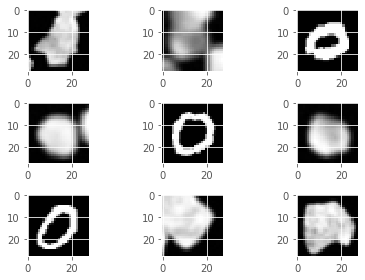

In [24]:
# summarize dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test:  X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(3,3,1+i)
    # plot raw pixel data
    plt.imshow(X_train[i].reshape(28,28),cmap="Greys")
# show the figure
plt.tight_layout()
plt.show()

In order to determine the right hyperparameters for your neural network, you will be rerunning your neural network with different parameters multiple times. It is helpful if you set up a pipeline in your code to make this process easier. Here we create a `load_dataset` and `prep_pixels` function to make it easy to load and prepare the data we need for training:

In [25]:
# load train and test dataset
def load_dataset():
    # load dataset
    all_dat     = np.asfarray(pd.read_csv('data/all_dat.csv'))
    # the first column is the labels
    all_imgs    = np.asfarray(all_dat[:, 1:])
    all_labels  = np.asfarray(all_dat[:, :1])
    
    # split into train:test
    trainX, testX, trainY, testY = train_test_split(all_imgs, all_labels,
                                                    test_size=0.1, stratify=all_labels,
                                                    random_state=13)
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

### Exercise 5: (20 min)

#### 5.1
What is the command for the convolutional layer we need to include in our model? (*Hint: [here](https://keras.io/layers/convolutional/) is the documentation.*)

(a) `Conv`

(b) `Conv1D`

(c) `Conv2D`

(d) `Conv3D`

**Answer.** The answer is (c). `Conv` is not a valid function. `Conv1D` is useful for temporal convolutions, which is not what we are looking for. `Conv3D` is for convolutions over volumes, but we are only in 2D space, so `Conv2D` is correct.

Before we begin defining our neural network architecture, be sure you are familiar with these key terms and parameters. You should be familiar with a few of them from the previous case:

1. **optimizer**: the optimization algorithm used to update weights in neural network training. A common optimizer is stochastic gradient descent.
1. **learning rate**: the influence of the gradient in updating the weights of the neural network at each step. Smaller values correspond to smaller (slower) updates; the default in `SGD` of `keras` is 0.01.
1. **momentum**: the influence of the previous step's change in weight on the next weight; the default in `SGD` of `keras` is 0.0.
1. **loss function**: the function that determines how to evaluate predictions from the model against the labeled data. A common loss function is mean squared error.

We know CNNs consist of a stack of layers that detect increasingly complex patterns, followed at the end by a handful of fully-connected layers that use those patterns to produce a final decision:

<img src=files/conv_layers.png width="500">

Accessed from [Towards Data Science](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2).

In CNNs, alternating layers of convolution and pooling serve to extract features from an image, starting with basic shapes (like lines in particular orientations) and soon expanding to complicated combinations of these basic shapes. In the end, fully-connected layers allow the network to decide a classification category based on the features that have been extracted by earlier layers.

Diagrams of CNNs will show how the original image gets progressively narrower and deeper, as one layer gets convoluted by several kernels (expanding the depth) in a **convolution layer** and then often compressed by a **pooling layer** (reducing the width). What starts out as a wide image with all the original pixels becomes a deep layer of features with less spatial information. So what is happening in these crucial convolution layers?

A **convolution** is an operation that finds patterns in an image (we also use the word to talk about the result of such an operation). You have seen how an image can be represented as a large matrix of numbers. A convolution consists of scanning it with a smaller matrix called a convolution **filter** (or kernel). As we scan the image with the filter, we get a single number for each location and put that number into a new matrix called the feature map. Each pixel in the filter gets multiplied by the corresponding pixel in the image, and the results are summed together. This is all that we need in order to start detecting edges, or even lines of particular orientations:

<img src=files/convolution_schematic.gif width="400">

Accessed from [WildML](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/).

Let's llook at how we would design a convolution filter that blurs an image:

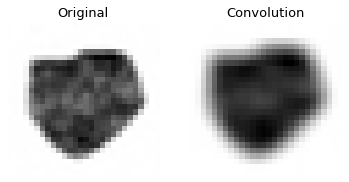

In [26]:
import scipy.ndimage as nd

# select a random image to manipulate
img = all_imgs[400].reshape(28,28)

conv_filter = np.array([[1,1,1,1],
                        [1,1,1,1],
                        [1,1,1,1],
                        [1,1,1,1]])

image_new = nd.convolve(img, conv_filter)

fig, axes = plt.subplots(1,2)
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Original', fontsize=13);
axes[0].axis('off');

axes[1].imshow(image_new, cmap=plt.cm.gray)    
axes[1].set_title('Convolution', fontsize=13);
axes[1].axis('off');

Once we have detected several features, we don't actually care about their precise location in the image. We want to preserve some spatial information, but we care more about the presence or absence of a feature and its *relative* location to others.

One way to get rid of all that extra spatial information is to **pool** the layer. This means dividing the layer into non-overlapping squares and performing an operation that aggregates them together. The most common operation is simply to output the maximum value found within that region. This turns a large matrix into a much smaller matrix with the maximum values of the previous.

By reducing the spatial information, we have fewer computations to perform and fewer parameters that could lead to overfitting. Each pooling step makes the image narrower, while preserving depth:

<img src="files/conv_vs_pool.gif" width="500"/>

Accessed from [Becoming Human](https://becominghuman.ai/what-exactly-does-cnn-see-4d436d8e6e52).

#### 5.2

Finish writing the function `define_model`, which returns the compiled neural network model, by filling in the `???`:

```
def define_model():
    model = ???
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=???))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(9, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(4, activation='softmax'))
    # compile model
    opt = SGD()
    model.compile(optimizer=opt, loss=???, metrics=['accuracy'])
    return model
```

**Answer.**

The first `???` should be `Sequential()`, since we are using `Sequential` in `keras` to build our deep learning models. You must create an empty model before adding layers in subsequent lines.

The second `???` should be `(28, 28, 1)`, because the input shape to a convolutional network must be a tensor (three channels). In our case, the last dimension is 1, but it does not suffice to write `(28, 28)`.

The third `???` should be `'categorical_crossentropy'` since we are in a multiclass classification setting.

The full code for `define_model` is:

In [27]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(9, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(4, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.0)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Take a moment to review the material about convolution, pooling, and the parts of the code in `define_model` that were already provided to you. Then answer the following questions to check your understanding:

#### 5.3

What is the **learning rate** (and how do you choose it)?

(a) A small positive number between 0.0 and 1.0

(b) A hyperparameter that controls the speed at which model weights are updated

(c) Another name is the "step size"

(d) All of the above

**Answer.** The answer is (d), because the learning rate is a small positive number that controls how quickly the model is adapting to the errors at each training iteration. Larger values can be advantageous because learning happens "faster," but it can also mean that the training finished with unstable or suboptimal weights. Smaller values can be advantageous because the learning is more precise, but it can also mean that the training takes much longer (or fails to train entirely). You want to test out different values of the learning rate to see which works best for your problem. You can read more about it [here](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

#### 5.4

What is the **momentum** (and how do you choose it)?

(a) A hyperparameter that controls how much the model weights are updated by the gradient

(b) A hyperparameter that controls how much the model weights are updated by the previous iteration's weights

(c) A hyperparameter that controls how much the learning rate is updated as the solution is approached

(d) All of the above

**Answer.** The answer is (b), because the change in weight equals the learning rate times the gradient, plus a momentum factor times the change in weight from the previous iteration. So (a) is the learning rate and (c) relates to learning rate updates, which is covered by adaptive learning rate algorithms.

#### 5.5

What is a **kernel initializer** (and how do you choose it)? This was not part of the common vocabulary list above, so take a moment to Google it in order to answer this question. You can find the documentation on the initializer parameter [here](https://keras.io/initializers/).

(a) It is the initial kernel function you use to model your class distributions (like a prior)

(b) It is a Boolean for whether or not you want a kernel function to initialize your weights

(c) It is the initial kernel function you use to initialize your weights

(d) None of the above

**Answer.** The answer is (c), because `kernel_initializer` is just a fancy term for which statistical distribution or function to use for initializing the neural network's weight parameters. As with any feature of a neural network, the wrong choice can make your neural network perform very poorly; there is often a range of "right" choices as long as you tune appropriately to avoid the bad ones (e.g. the identity intializer only works properly with square tensors). There are different default values in `keras` depending on the type of layer. You probably need to put less effort into choosing the bias initializer, for instance, because empirically this does not affect performance and convergence as much. You can read more about choosing kernel initializers [here](https://becominghuman.ai/priming-neural-networks-with-an-appropriate-initializer-7b163990ead).

#### 5.6

Which of the following statements are true about the **pooling layer** in this neural network architecture?

(a) When the input is images, pooling layers help make the neural network invariant to translation: the image can be shifted by a few pixels, but the model will still recognize it.

(b) Pooling layers are not optional; they must be inserted after a convolutional layer, otherwise the neural network is not even functionally feasible.

(c) Pooling layers help to reduce the dimensionality of a large, complex signal (like an image) by only keeping the most relevant features.

(d) Pooling layers always selects the maximum value from a patch of features, but you can choose the window and stride size.

**Answer.** The answer is that (a) and (c) are true. Option (b) is false because pooling layers are optional; while they are a common and robust way to downsample from a convolutional layer, they are not required. Down sampling can be achieved with convolutional layers by changing the stride of the convolution across the image as well. Option (d) is false because there are many types of pooling layers: *maximum* is certainly a common one (we are using in this case) but there are many others (*average* is another common one).

In [28]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    dataY_asfactor = [np.argmax(y) for y in dataY] # StratifiedKFold doesn't want one-hot encoded
    for train_ix, test_ix in kfold.split(dataX, dataY_asfactor):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, batch_size=3, epochs=30, validation_data=(testX, testY), verbose=False)
        # evaluate model
        y_pred = model.predict_classes(testX, verbose=False)
        y_true = [np.argmax(y) for y in testY]
        # print(confusion_matrix(y_true, y_pred))
        _, acc = model.evaluate(testX, testY, verbose=True)
        print('> %.3f' % (acc * 100.0))
        # store scores
        scores.append(acc)
        histories.append(history)
    print("")
    print(model.summary())
    print("")
    return scores, histories

In [29]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.tight_layout()
    plt.show()

In [30]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print("")
    print('Accuracy: mean=%.3f, std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [31]:
# run the test harness for evaluating a model
def run_test_harness(prep_pixels=False):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    if prep_pixels:
        trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY, n_folds=10)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

108/108 [==============================] - 0s 90us/step
> 80.556
108/108 [==============================] - 0s 84us/step
> 75.926
108/108 [==============================] - 0s 89us/step
> 75.926
108/108 [==============================] - 0s 82us/step
> 94.444
108/108 [==============================] - 0s 147us/step
> 75.000
108/108 [==============================] - 0s 74us/step
> 90.741
108/108 [==============================] - 0s 74us/step
> 50.000
108/108 [==============================] - 0s 74us/step
> 90.741
108/108 [==============================] - 0s 78us/step
> 85.185
108/108 [==============================] - 0s 79us/step
> 50.000

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 8)         0     

/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.p

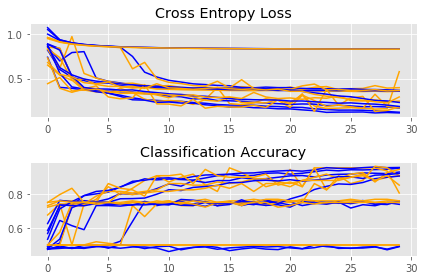


Accuracy: mean=76.852, std=14.919, n=10


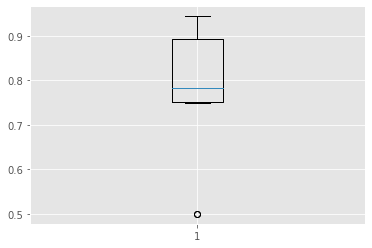

In [32]:
run_test_harness()

All of the following are features of the model we could explore or add in order to improve our model's performance:
* learning rate;
* batch normalization;
* model depth.

Let's add more convolutional and pooling layers with the same-sized filter to our model and see how our performance changes. (When I tried batch normalization, it did not improve the model.)

In [33]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(2, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(4, activation='softmax'))
    # compile model
    opt = SGD()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

108/108 [==============================] - 0s 116us/step
> 50.000
108/108 [==============================] - 0s 109us/step
> 89.815
108/108 [==============================] - 0s 112us/step
> 84.259
108/108 [==============================] - 0s 102us/step
> 81.481
108/108 [==============================] - 0s 98us/step
> 90.741
108/108 [==============================] - 0s 94us/step
> 92.593
108/108 [==============================] - 0s 93us/step
> 92.593
108/108 [==============================] - 0s 170us/step
> 90.741
108/108 [==============================] - 0s 93us/step
> 91.667
108/108 [==============================] - 0s 101us/step
> 87.963

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 13, 13, 8)         0

/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/Users/jlynch/opt/anaconda3/envs/case_18.3/lib/python3.7/site-packages/ipykernel_launcher.p

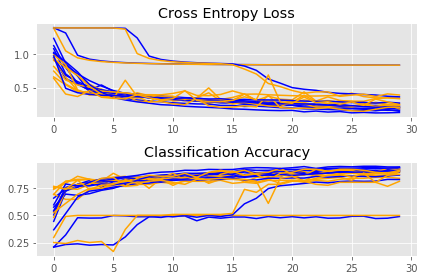


Accuracy: mean=85.185, std=12.228, n=10


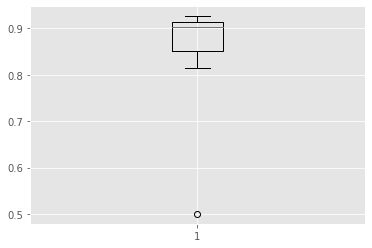

In [34]:
run_test_harness()

---

As we can see, working with raw images can be very challenging. On the one hand, images contain a lot of data (a single image in our dataset is 784 pixels, and we have pretty *low* resolution); on the other hand, images also contain a lot of noise and redundancy (e.g. high spatial correlations, random effects from lighting and blur). Often, when working with data that has a low signal-to-noise ratio, it is useful to use a more mechanistic preprocessing approach to transform the data into a subspace that has higher signal-to-noise. These preprocessing steps should apply relevant domain-specific knowledge to the data in order to "concentrate" key parts of the signal. In our example, biologists may be able to screen a few dozen images and point out relevant features of the images to distinguish between different mutations:

1. "The normal cells appear more elliptical in shape."
2. "The second mutation appears to have generally darker and denser cells."
3. "The first mutation results in cells with more jagged edges."
4. "We would expect the mutant cells to clump more together."

Each of these human observations could be written as a quantitative measure:

1. Shape
2. Color
3. Eccentricity
4. Proximity

Computer vision algorithms can translate raw images into some of the features mentioned in these observations. For our images, we know that there is a cell object in the middle with a dark background. Separating an image into multiple (hopefully relevant) segments is known as **image segmentation**. Here is an example of image segmentation for a self-driving car:

<img src=files/self-driving-car.gif width="600">

Here is diagram of how image segmentation is incorporated into a cell analysis pipeline:

<img src=files/cell_analysis_pipeline.png width="600">

The dataset we will analyze in the next part of the case is 50 features automatically extracted for every single cell in our image dataset using computer vision algorithms (customized to images of cells captured through fluorescent microscopy):

In [35]:
feature_dat = pd.read_csv('data/feature_dat.csv')
print(feature_dat.shape)
feature_dat.head()

(1200, 51)


,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,color1,color2,...,proxi2,proxi3,proxi4,proxi5,proxi6,proxi7,proxi8,hrlck1,hrlck2,mutation
0,-0.000002,-0.000006,0.000338,-6.223100e-06,5.723900e-05,0.000472,0.052716,0.052722,0.052383,0.095004,...,4.4449,0.836480,-1.5031,-1.5029,1.150963,1.670230,-1.4964,0.231260,4.662331,0
1,0.000023,0.000022,-0.000043,7.678700e-07,1.663000e-05,-0.000189,0.055287,0.055265,0.055308,0.071142,...,8.4147,1.839299,-1.5025,-1.5027,1.992683,2.807464,-1.5055,1.532233,5.196261,0
2,-0.000022,0.000004,0.000362,1.681700e-06,-1.189500e-05,-0.000167,0.006509,0.006505,0.006143,0.019397,...,5.7082,-0.575317,-1.4975,-1.4969,-1.057035,-1.575473,-1.4984,-1.846138,5.158199,0
3,0.000003,0.000005,0.000006,1.402100e-06,7.705300e-07,0.000008,0.059301,0.059296,0.059290,0.110130,...,2.8404,0.611047,-1.4967,-1.4967,1.118759,1.667009,-1.4972,1.995589,4.610642,0
4,-0.000008,-0.000049,0.000103,2.089200e-06,-9.886500e-05,-0.000121,0.010542,0.010591,0.010488,-0.020250,...,6.4415,1.607215,-1.5066,-1.5065,1.959528,2.804148,-1.4979,0.583515,4.916569,0


This is an example of how an image is translated into a few of the extracted features you see in the table.

<img src=files/cell_extraction.png width="800">

## Building and and training simpler classifiers (25 min)

Let's now build and train simpler classifiers on the engineered features extracted from the images. Now that we have transformed our images to a more "classical" dataset, we can choose a model from our familiar suite of classification tools. Here, we will be using the random forest classifier and $L_1$-regularized (LASSO) logistic regression.

### Exercise 6: (15 min)

#### 6.1

Which of the following characteristics, if present, could make the predictive performance of the random forest **superior** to that of the neural network?

(a) the extracted features are better discriminators than the features the neural network could learn

(b) the extracted features are less correlated than the pixels in the raw images

(c) the extracted features result in faster convergence for the random forest

(d) the data is highly nonlinear, which lends advantage to the highly flexible random forest

**Answer.** The answer is (a), because (b) is almost certainly true (plus random forests deal well with multicollinearities anyway and convolutional neural networks are designed to take advantage of the appropriate spatial correlations between pixels). (c) relates to computational performance and not predictive performance. As for (d), the data is almost certainly nonlinear, but this should result in better performance for the neural network, not the random forest.

In [36]:
# collect data and train:test split
X = feature_dat.drop("mutation", axis=1)
Y = feature_dat.mutation

X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.1, random_state=13)

# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fit the random forest classifier
classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=13)
classifier.fit(X_train, y_train)

# make predictions on the training set
y_pred_train = classifier.predict(X_train)
print("accuracy train: ", round(np.mean(y_pred_train == y_train), 2))

# make predictions on the test set
y_pred = classifier.predict(X_test)
print("accuracy test:  ", round(np.mean(y_pred == y_test), 2))

print("")
print("confusion matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("")
for i in range(4):
    print("mutant " + str(i) + ",",
          "precision: ", round(ANN.precision(i, cm), 2),
          " recall: ", round(ANN.recall(i, cm), 2))

accuracy train:  1.0
accuracy test:   0.88

confusion matrix:
[[34  2  0  1]
 [ 1 18  2  0]
 [ 2  4 21  1]
 [ 0  1  0 33]]

mutant 0, precision:  0.92  recall:  0.92
mutant 1, precision:  0.72  recall:  0.86
mutant 2, precision:  0.91  recall:  0.75
mutant 3, precision:  0.94  recall:  0.97


#### 6.2

Using the code above from a single iteration of the random forest, write a function `evaluate_rfmodel` that is very similar to `evaluate_model` from the neural network test harness.

**Answer.**

In [37]:
# evaluate random forest model using k-fold cross-validation
def evaluate_rfmodel(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX, dataY):
        # define model
        model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=13)
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # scale features
        scaler = StandardScaler()
        trainX = scaler.fit_transform(trainX)
        testX = scaler.transform(testX)
        # fit model
        history = model.fit(X_train, y_train)
        # evaluate model
        y_pred = model.predict(testX)
        y_true = testY
        # print(confusion_matrix(y_true, y_pred))
        acc = np.mean(y_pred == y_true)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

If your code for 6.2 works correctly, the following code should print the accuracy at each fold, a summary of the distribution of accuracies, and a boxplot visualizing them:

> 98.333
> 97.500
> 98.333
> 98.333
> 96.667
> 100.000
> 98.333
> 99.167
> 98.333
> 97.500

Accuracy: mean=98.250, std=0.870, n=10


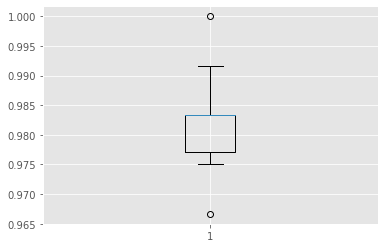

In [38]:
scores, _ = evaluate_rfmodel(np.asarray(X), np.asarray(Y), n_folds=10)
summarize_performance(scores)

#### 6.3

Does the random forest appear to outperform the neural network?

(a) yes

(b) no, they are the same

(c) no, the random forest is worse

(d) not enough information

**Answer.** The answer is (a) because in all five folds, the random forest classified with greater accuracy than the neural network.

So far, we have been very focused on blindly predicting mutations. We say "blindly" because we are not investigating which features of the images appear to be the most useful discriminators. Both the random forest and neural network we have used so far have good predictive power, but are more difficult to interpret. This is why the last "simpler" model we will consider is LASSO logistic regression.

Often, we are interested in both high predictive power as well as some sort of inference - can we generate new hypotheses about these mutations based on which features our models seem to use? LASSO logistic regression (as compared to regular logistic regression) is useful in that it sets less "relevant" coefficients to zero to give us an idea of which features in the data are the best discriminators. Below, we are using an $L_1$-penalized logistic regression classifer on our dataset of features extracted from the cell images:

In [39]:
def run_lasso_model(X_train,X_test,y_train,y_test,alpha,max_iter=10e4):
    lasso = LogisticRegression(solver='saga',
                        multi_class='multinomial',
                        penalty='l1',
                        C=alpha,
                        max_iter=max_iter,
                        random_state=13,
                        verbose=True)
    lasso.fit(X_train, y_train)
    coeff_used = np.sum(lasso.coef_!=0)
    train_acc = lasso.score(X_train, y_train)
    test_acc = lasso.score(X_test, y_test)
    return(lasso.coef_, coeff_used, train_acc, test_acc)

lasso01coef, coeff_used, train_acc, test_acc = run_lasso_model(X_train,X_test,y_train,y_test,1.0)
print("------------------------------------------------------")
print("|                 alpha=1.0                          |")
print("------------------------------------------------------")
print("accuracy train    :", round(train_acc, 3))
print("accuracy test     :", round(test_acc, 3))
print("number of features:", coeff_used)

lasso001coef, coeff_used, train_acc, test_acc = run_lasso_model(X_train,X_test,y_train,y_test,0.1)
print("------------------------------------------------------")
print("|                 alpha=0.1                          |")
print("------------------------------------------------------")
print("accuracy train    :", round(train_acc, 3))
print("accuracy test     :", round(test_acc, 3))
print("number of features:", coeff_used)

lasso0001coef, coeff_used, train_acc, test_acc = run_lasso_model(X_train,X_test,y_train,y_test,0.01)
print("------------------------------------------------------")
print("|                 alpha=0.01                         |")
print("------------------------------------------------------")
print("accuracy train    :", round(train_acc, 3))
print("accuracy test     :", round(test_acc, 3))
print("number of features:", coeff_used)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 969 epochs took 2 seconds
------------------------------------------------------
|                 alpha=1.0                          |
------------------------------------------------------
accuracy train    : 0.969
accuracy test     : 0.925
number of features: 74


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 158 epochs took 0 seconds
------------------------------------------------------
|                 alpha=0.1                          |
------------------------------------------------------
accuracy train    : 0.956
accuracy test     : 0.925
number of features: 19
convergence after 31 epochs took 0 seconds
------------------------------------------------------
|                 alpha=0.01                         |
------------------------------------------------------
accuracy train    : 0.903
accuracy test     : 0.892
number of features: 6


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


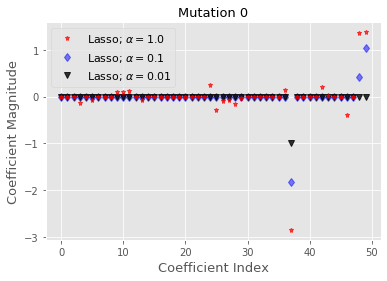

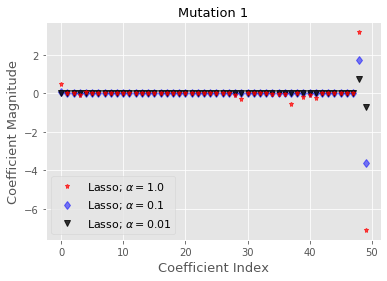

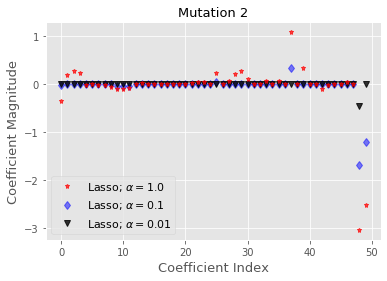

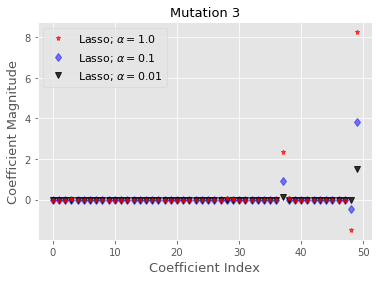

In [40]:
for mutant in range(4):
    plt.plot(lasso01coef[mutant],alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1.0$',zorder=7)
    plt.plot(lasso001coef[mutant],alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.1$')
    plt.plot(lasso0001coef[mutant],alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.01$')
    plt.title('Mutation ' + str(mutant),fontsize=13)
    plt.xlabel('Coefficient Index',fontsize=13)
    plt.ylabel('Coefficient Magnitude',fontsize=13)
    plt.legend(fontsize=11,loc='best')
    plt.show()

In [41]:
for mutant in range(4):
    print("")
    print("mutant " + str(mutant) + "..............")
    idx = lasso001coef[mutant]!=0
    cof = pd.DataFrame({'feature': X.columns[idx], 'coefficient': lasso001coef[mutant][idx]})
    cof = cof.sort_values(by='coefficient', ascending=False)
    print(cof)


mutant 0..............
  feature  coefficient
3  hrlck2     1.028128
2  hrlck1     0.425336
0  rotat2    -0.012827
1  eccen6    -1.813412

mutant 1..............
  feature  coefficient
1  hrlck1     1.707777
0  shape1     0.039975
2  hrlck2    -3.632688

mutant 2..............
  feature  coefficient
5  eccen6     0.333918
4  rotat2     0.036392
6  eccen8     0.004081
0  shape1    -0.025462
1  color2    -0.038990
2  color3    -0.039934
3  color4    -0.053030
8  hrlck2    -1.209041
7  hrlck1    -1.680485

mutant 3..............
  feature  coefficient
2  hrlck2     3.816921
0  eccen6     0.920117
1  hrlck1    -0.452518


### Exercise 7: (5 min)

#### 7.1
Approximately how many of the original features seem to be needed for the LASSO to achieve a classification accuracy on the test set above 92%?

(a) all 50 features;

(b) ~20 features;

(c) ~10 features;

(d) ~3 features.

**Answer.** The answer is (c), because we can see that the classifier achieves above 92% accuracy on the test set using only 9 unique features in total.

#### 7.2
Which mutation appears to be associated with higher values on the `hrlck2` feature?

(a) Mutant 0;

(b) Mutant 1;

(c) Mutant 2;

(d) Mutant 3.

**Answer.** The answer is (d), because the `hrlck2` coefficient is largest for Mutant 3.

## Comparing our classifiers (15 min)

### Exercise 8: (15 min)

#### 8.1
Compare the **classification accuracies** of the different classifiers. Are they statistically significantly different?

(a) neural network > random forest > LASSO

(b) random forest > LASSO > neural network

(c) random forest = LASSO > neural network

(d) LASSO > random forest = neural network

**Answer.** The answer is (b), because the random forest has consistently, significantly higher classification accuries than the LASSO, which has consistently, significantly higher classification accuracies than the neural network.

#### 8.2
Compare the **computational costs** of the different classifiers. (Don't forget to factor in computation time for image processing and feature extraction.)

**Answer.** All models require a substantial amount of time preprocessing the data. For the neural network, the images must be scaled, cropped, and color-adjusted appropriately. For the random forest classifier, basically the same steps need to be performed, plus the computer vision algorithms need to extract the features used. However, the neural network computationally generally takes more time to train. Both models, once trained, take comparable amounts of time to run. So overall, it seems the simpler classifier requires more preparation work due to feature extraction and for large datasets the neural network would take more time to train. The caveat is that if you are using out-of-the-box computer vision algorithms for your feature extraction, then this time cost for the simpler classifier would be substantially reduced, of course.

#### 8.3
Compare the **interpretability** among the different classifiers. If you want to understand how certain visual profiles relate to mutation differences, which model is easier to understand?

**Answer.** Neither the neural network model nor the random forest is particularly interpretable, compared to parametric methods like logistic regression. The random forest classifier is slightly more interpretable since there are underlying decision trees we could investigate. However, there are also many tools available to "interpret" the layers of a neural network. For instance, visualizing the embeddings can provide insight into the types of intermediary features your classifier is learning.

<img src=files/deep_layers_learning_features.png width="500">

Accessed from [DataRobot](https://blog.datarobot.com/a-primer-on-deep-learning).

#### 8.4
For each classifier, state at least one thing you could do to further improve your classification accuracy.

**Answer.**
1. neural network: we could try further hyperparameter tuning via crossvalidation, add more layers, or add more features.
1. random forest: the classification accuracy is already so high, the only thing we might want to consider is getting more test data to stress-test our model.
1. LASSO: we could collect additional features, or attempt to capture nonlinear relationships by trying a [**sparse generalized additive model**](https://arxiv.org/pdf/1506.03850).

#### 8.5
What is your biggest concern with the validity of the results we found today?

**Answer.** From our data exploration, we see that some images look vastly different from each other for reasons that may not be biological. We want to adjust for these biases in order to ensure our neural network is not overfitting on the idiosyncracies of the training data we had available and also generalizes well to other datasets. One approach could be to use a [**generative adversarial network**](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29) to train a model that does not pick up on, say, lighting differences or lab differences.

---

## Takeaways (5 min)

In this case, we learned about the challenges of working with image data. Classifying hundreds of pre-cleaned images into four categories is a relatively standard task, yet we learned some important lessons and also about further challenges that manifest as complexity increases. If we have raw images, more images, larger images, more classes, or more inferential (vs. predictive) questions, this problem can become even trickier. Here are a few important takeaways from our case today:

1. **Preprocessing, preprocessing, preprocessing.** Most of your time will be spent understanding and then processing your raw data. This can be as simple as cropping your images or as complex as adjusting for color, brightness, blur, etc. Often, substantial improvements in predictive performance can be achieved with smarter preprocessing!
2. **Neural networks can be really useful... sometimes.** Our comparison of the neural network performance with a random forest classifier showed us that neural networks do not always have meaningfully better performance. It is wisest to start out with the simplest models you can and only begin to use neural networks if you have huge datasets and highly nonlinear relationships.
3. **Convolutional neural networks can be useful when working with large signal data** (e.g. image, audio, video). We learned that CNNs are a type of neural network especially adapted to working with input data that is very big and has some sort of dependence structure (e.g. spatial). Just like any other model, they are not always useful and can have very poor performance in the wrong settings.

You also were introduced to a lot of new code in deep learning libraries today. It's quite a lot to stomach, so please review the technical material in this case again on your own time to really familiarize yourself with how to implement CNNs in practice.

---

### Appendix A: A remark on CNNs with input images of different dimensions

In this case, you were working with a preprocessed dataset of images, where the images were already made to have the same size and dimensions. In real life, you may be handed a far messier dataset where the images are not the same dimensions, resolution, or size. Cleaning and processing them can take up valuable data science time. So, does this matter?

### Bonus Question:

Which of the following types of neural network layers are invariant to image size?

(a) fully-connected

(b) convolutional

(c) max-pooling

(d) batch normalization layers

**Answer.** Only (a) is **not** invariant to the size of the image. All other types of layers listed above can accept images of any dimension. Learn more [here](https://ai.stackexchange.com/questions/6274/convolutional-neural-networks-with-input-images-of-different-dimensions-image).

---

### Appendix B: A remark on deep learning libraries

As a data scientist, you should at least be familiar with the big players: `Keras`, `PyTorch`, and `TensorFlow`. `Keras` is currently the gold standard for building neural networks in the applied space (which is why we are teaching it to you). You can learn more about their strengths, weaknesses, and history [here](https://www.quora.com/What-are-the-major-differences-between-TensorFlow-Keras-and-PyTorch).

<img src=files/keras_tensorflow_decision.png width="500">

Accessed from [Quora](https://www.quora.com/What-are-the-major-differences-between-TensorFlow-Keras-and-PyTorch).

---

### Appendix C: A remark on other neural network architectures

There are dozens of other architectures (and corresponding learning algorithms) out there for different types of data, questions, and constraints. You don't need to understand all of them, but you should be aware of what is out there:

<img src=files/chart_of_neural_networks.png width="700">

Accessed from [Stack Exchange](https://ai.stackexchange.com/questions/5546/what-is-the-difference-between-a-convolutional-neural-network-and-a-regular-neur).